In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from matplotlib.pyplot import subplots
import statsmodels.api as sm

In [ ]:
#Load data
df = pd.read_csv("data_1000_samples.txt", delimiter=" ")


#Remove min_U_distance column since all values are Inf
df.drop(columns=["min_U_distance"], inplace=True)
#Drop rows where any value is inf or -inf
df = df[~df.isin([np.inf, -np.inf]).any(axis=1)].copy()

# Filter for axon nodes
df = df[df["src_node_type"] == "axon"].copy()

#Extract Neuron of interest
filtered_df = df[(df['src_neuron_ID'] == 5704424)]
#Keep rows where 'src_neuron_ID' is NOT equal to 57004424
df = df[df['src_neuron_ID'] != 57004424].copy()

In [ ]:
#True values on neurons
neu_test = filtered_df['num_synapses']

In [ ]:
#BCE loss to use later
from sklearn.metrics import log_loss

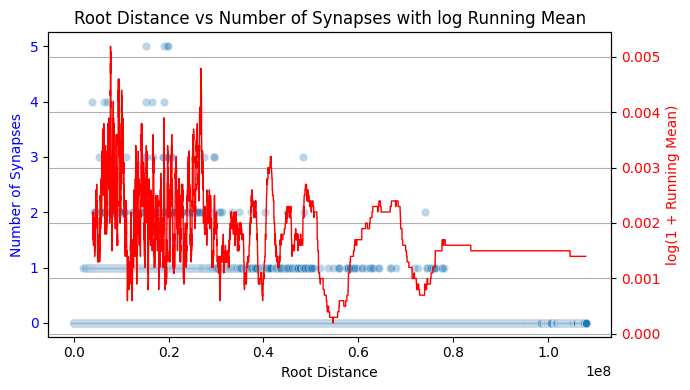

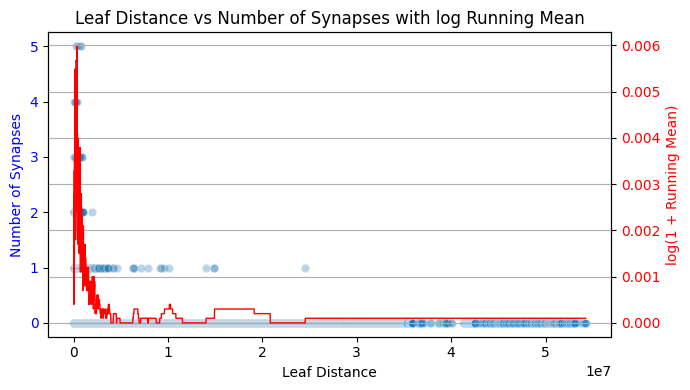

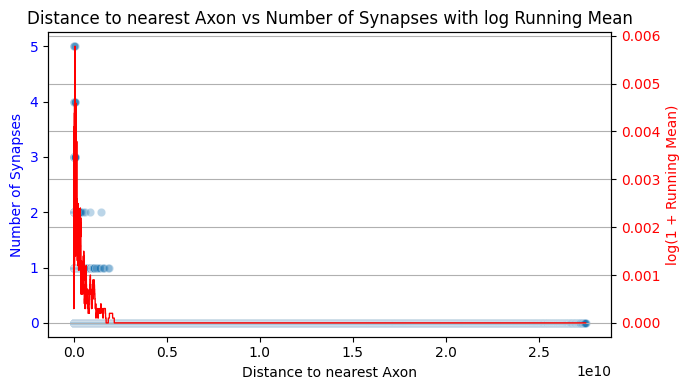

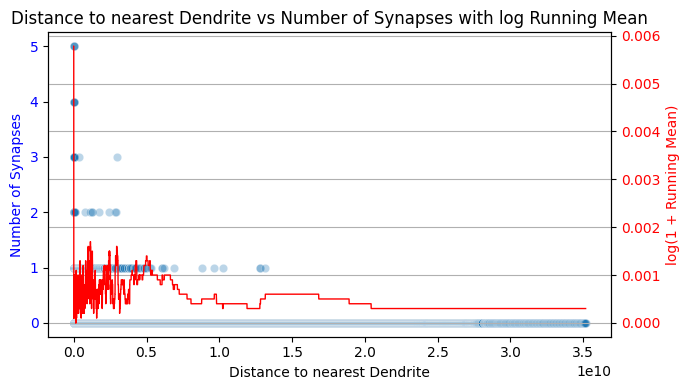

In [ ]:
# Covariates to plot
covariates = {
    'root_dist': 'Root Distance',
    'leaf_dist': 'Leaf Distance',
    'min_A_distance': 'Distance to nearest Axon',
    'min_D_distance': 'Distance to nearest Dendrite'
}

window = 10000  # Rolling window for running mean
n = 100000
for feature, label in covariates.items():
    # Sort values for consistent rolling
    sorted_df = df[[feature, "num_synapses"]].sort_values(by=feature).reset_index(drop=True)
    # Compute rolling mean and then log-transform it
    rolling_mean = sorted_df["num_synapses"].rolling(window=window, min_periods=1).mean()
    log_rolling_mean = np.log1p(rolling_mean)

    # Create the plot
    fig, ax1 = plt.subplots(figsize=(7, 4))

    # Scatter plot on left y-axis
    sns.scatterplot(x=sorted_df[feature], y=sorted_df["num_synapses"], alpha=0.3, ax=ax1)
    ax1.set_xlabel(label)
    ax1.set_ylabel("Number of Synapses", color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Log of running mean on right y-axis
    ax2 = ax1.twinx()
    ax2.plot(sorted_df[feature].iloc[n:], log_rolling_mean.iloc[n:], color='red', linewidth=1)
    ax2.set_ylabel("log(1 + Running Mean)", color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    plt.title(f"{label} vs Number of Synapses with log Running Mean")
    fig.tight_layout()
    plt.grid(True)
    plt.show()


In [ ]:
#Split data into training and test data
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
train_df["num_synapses"] = train_df["num_synapses"].apply(lambda x: 1 if x >= 1 else x)
test_df["num_synapses"] = test_df["num_synapses"].apply(lambda x: 1 if x >= 1 else x)

#Separate covariate from target variable
X_train = train_df.drop(columns=["num_synapses"])  #Features
y_train = train_df["num_synapses"]               #Target
X_test= test_df.drop(columns=["num_synapses"])  #Features
y_test = test_df["num_synapses"]               #Target


#Relevant features
features = ['leaf_dist',
            'root_dist',
            'min_A_distance',
            'min_D_distance',
            'min_N_distance'
            ]

Xtr = X_train[features]
Xte = X_test[features]

In [ ]:
#Import required libraries
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#Add intercept term
X_tr = sm.add_constant(Xtr)
X_te = sm.add_constant(Xte)

#Fit simple logistic regression model
glm1 = sm.GLM(y_train,
X_tr,
family=sm.families.Binomial())
results1 = glm1.fit()
print(results1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           num_synapses   No. Observations:              1066872
Model:                            GLM   Df Residuals:                  1066867
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14250.
Date:                Sun, 08 Jun 2025   Deviance:                       28501.
Time:                        15:46:27   Pearson chi2:                 1.06e+08
No. Iterations:                    13   Pseudo R-squ. (CS):           0.001149
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -5.4717      0.047   -115.

In [ ]:
#Investigation of first-order interactive terms
formula = 'num_synapses ~ leaf_dist + min_A_distance + min_D_distance + root_dist + min_N_distance + leaf_dist:root_dist + leaf_dist:min_A_distance + leaf_dist:min_D_distance +root_dist:min_A_distance + root_dist:min_D_distance + min_A_distance:min_D_distance'

import statsmodels.formula.api as smf

X_tr_int = X_tr.copy()
X_tr_int['num_synapses'] = y_train

#Fit logistic regression with interactions
interaction_model = smf.logit(formula=formula, data=X_tr_int)
interaction_result = interaction_model.fit()

#View the summary with coefficients and p-values
print(interaction_result.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.
         Current function value: 0.011587
         Iterations 29
                           Logit Regression Results                           
Dep. Variable:           num_synapses   No. Observations:              1066872
Model:                          Logit   Df Residuals:                  1066860
Method:                           MLE   Df Model:                           11
Date:                Sat, 07 Jun 2025   Pseudo R-squ.:                  0.1683
Time:                        14:53:33   Log-Likelihood:                -12362.
converged:                       True   LL-Null:                       -14864.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -4.7149      0.054    -87.634      0

/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


In [ ]:
#Test set predictions and confusion matrix
probs2 = interaction_result.predict(X_te)
preds2 = (probs2 > 0.5).astype(int)
print(confusion_matrix(y_test, preds2))

/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


[[266235      0]
 [   484      0]]


In [ ]:
#Investigation of first-order interactive terms
formula = 'num_synapses ~ leaf_dist + min_A_distance + min_D_distance + root_dist + leaf_dist:root_dist + min_A_distance:min_D_distance'

#Fit logistic regression with interactions
interaction_model_2 = smf.logit(formula=formula, data=X_tr_int)
interaction_result_2 = interaction_model_2.fit()

#View the summary with coefficients and p-values
print(interaction_result_2.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.
         Current function value: 0.011590
         Iterations 28
                           Logit Regression Results                           
Dep. Variable:           num_synapses   No. Observations:              1066872
Model:                          Logit   Df Residuals:                  1066865
Method:                           MLE   Df Model:                            6
Date:                Fri, 06 Jun 2025   Pseudo R-squ.:                  0.1681
Time:                        12:39:50   Log-Likelihood:                -12365.
converged:                       True   LL-Null:                       -14864.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -4.6900      0.049    -95.201      0

/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


In [ ]:
#Predictions on test data
probs2 = interaction_result_2.predict(X_te)
preds2 = (probs2 > 0.5).astype(int)
print(confusion_matrix(y_test, preds2))

[[266235      0]
 [   484      0]]


/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


In [ ]:
#Test on relevant neurons
fil_df = filtered_df[features]
fil_df = sm.add_constant(fil_df)
neu_prob = interaction_result_2.predict(fil_df)

neu_pred = (neu_prob > 0.5).astype(int)
print(confusion_matrix(neu_test, neu_pred))
filtered_df['log_prob'] = neu_prob
filtered_df

NameError: name 'interaction_result_2' is not defined

In [ ]:
#Investigation under SMOTE
from imblearn.over_sampling import SMOTE

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_tr, y_train)

# Add constant for intercept in statsmodels
X_resampled = sm.add_constant(X_resampled)

#Fit model
glm3 = sm.GLM(y_resampled,
X_resampled,
family=sm.families.Binomial())
results3 = glm3.fit()
print(results3.summary())

In [ ]:
# Get the fitted parameters
params3 = results3.params

# Manually compute the linear predictor for the test data
# The linear predictor is X * beta
linear_predictor = np.dot(X_te, params3)

# Compute the predicted probabilities using the inverse logit function
# For Binomial GLM with logit link, the inverse link is the sigmoid function
# P(Y=1|X) = sigmoid(linear_predictor) = 1 / (1 + exp(-linear_predictor))
probs3 = 1 / (1 + np.exp(-linear_predictor))

# Convert probabilities to binary predictions (0 or 1)
preds3 = (probs3 > 0.5).astype(int)

# Print the confusion matrix
print(confusion_matrix(y_test, preds3))

[[126427 139808]
 [    74    410]]


In [ ]:
# Compute binary cross-entropy loss
bce_loss3 = log_loss(y_test, probs3)

print(f"Binary Cross-Entropy Loss on Test Set: {bce_loss3}")

Binary Cross-Entropy Loss on Test Set: 0.6229539463961961


In [ ]:
#Adjust X_tr and X_te
X_tr = X_tr.drop(columns=["const", 'min_N_distance'])
X_te = X_te.drop(columns=["const",'min_N_distance'])
fil_df = fil_df.drop(columns=["const",'min_N_distance'])

In [ ]:
#We now move onto tree-based methods
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#Start with basic decision tree classifier

#Initialize and fit the model
clf = DTC(max_depth=3, random_state=42)
clf.fit(X_tr, y_train)

#Predict on test set
y_pred = clf.predict(X_te)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test , y_pred))


In [ ]:
#Plot tree
from sklearn.tree import plot_tree
plt.figure(figsize=(30, 15))
plot_tree(clf,
          feature_names=X_tr.columns,
          class_names=["No Synapse", "Synapse"],
          filled=True,
          rounded=True,
          fontsize=15)
plt.show()

In [ ]:
#Confusion matrix of simple tree on test set
pred_tree = clf.predict(X_te)
print(confusion_matrix(y_test, pred_tree))

[[266235      0]
 [   484      0]]


In [ ]:
#Now move on to bagging
from sklearn.ensemble import RandomForestClassifier
#1. Initialize the classifier
bag_clf = RandomForestClassifier(
    n_estimators=100,
    max_features = 7,
    oob_score=True,
    max_depth=5,
    random_state=42,
    n_jobs=-1  # use all cores
)
#2. Fit on training data
bag_clf.fit(X_tr, y_train)

#3. Predict on test set
y_pred = bag_clf.predict(X_te)

#4. Evaluate performance
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

print(f"OOB Score: {bag_clf.oob_score_:.4f}")

Confusion Matrix:
[[266235      0]
 [   484      0]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9982    1.0000    0.9991    266235
           1     0.0000    0.0000    0.0000       484

    accuracy                         0.9982    266719
   macro avg     0.4991    0.5000    0.4995    266719
weighted avg     0.9964    0.9982    0.9973    266719

OOB Score: 0.9981


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
#Random forest
#1. Initialize the classifier
rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_features = 2,
    oob_score=True,
    max_depth=5,
    random_state=42,
    n_jobs=-1  # use all cores
)
#2. Fit on training data
rf_clf.fit(X_tr, y_train)

#3. Predict on test set
y_pred = rf_clf.predict(X_te)

#4. Evaluate performance
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

Confusion Matrix:
[[266235      0]
 [   484      0]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9982    1.0000    0.9991    266235
           1     0.0000    0.0000    0.0000       484

    accuracy                         0.9982    266719
   macro avg     0.4991    0.5000    0.4995    266719
weighted avg     0.9964    0.9982    0.9973    266719



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
#Boosting
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the model
boost_clf = GradientBoostingClassifier(
    n_estimators=100,     # number of boosting rounds
    learning_rate=0.1,    # shrinkage rate (default 0.1)
    max_depth=4,          # depth of each tree
    random_state=42
)

# Fit the model
boost_clf.fit(X_tr, y_train)

# Predict on test data
y_pred = boost_clf.predict(X_te)

# Evaluate
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[266185     50]
 [   484      0]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    266235
           1       0.00      0.00      0.00       484

    accuracy                           1.00    266719
   macro avg       0.50      0.50      0.50    266719
weighted avg       1.00      1.00      1.00    266719



In [ ]:
#Prediction on large test data
boost_probs = boost_clf.predict_proba(X_te)
boost_loss = log_loss(y_test, boost_probs)
print(f"Binary Cross-Entropy Loss on Test Set: {boost_loss}")

Binary Cross-Entropy Loss on Test Set: 0.012360693122915286


In [ ]:
#Prediction on relevant neurons
boost_probs = boost_clf.predict_proba(fil_df)
filtered_df['boost_probs' ] = boost_probs[:,1]

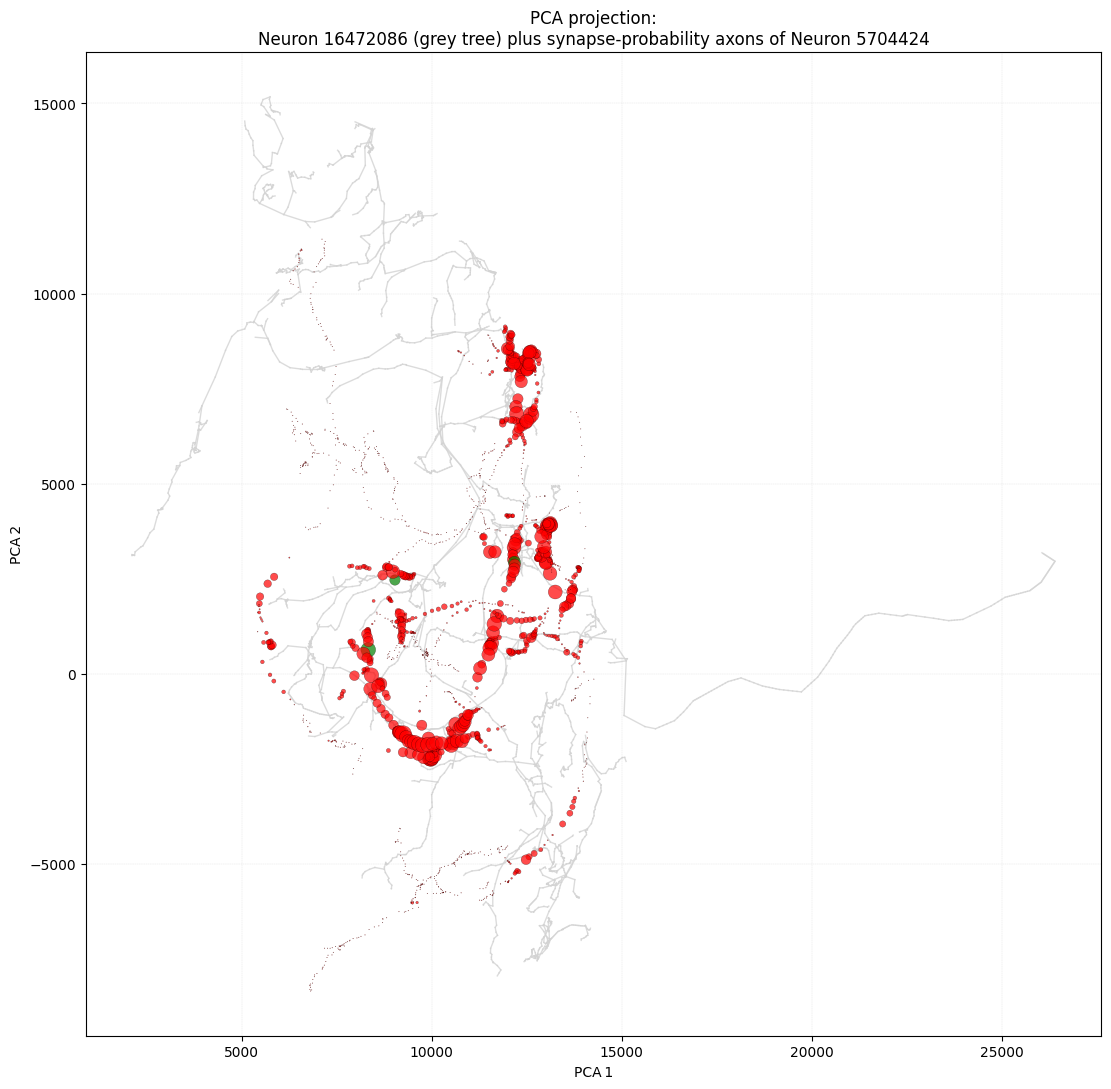

In [ ]:
from sklearn.decomposition import PCA
#Load morphologies  &  predicted probabilities
df1 = pd.read_csv("morpho_neuron-ID_5704424.csv")   # presynaptic neuron
df2 = pd.read_csv("morpho_neuron-ID_16472086.csv")  # postsynaptic neuron

#Build a common 2-D PCA projection
both_coords = pd.concat([df1[['x', 'y', 'z']], df2[['x', 'y', 'z']]], ignore_index=True)
pca_xy      = PCA(n_components=2).fit_transform(both_coords)

#split back to neuron-specific arrays
pca1 = pca_xy[:len(df1)]
pca2 = pca_xy[len(df1):]

df1["pca1"], df1["pca2"] = pca1[:, 0], pca1[:, 1]
df2["pca1"], df2["pca2"] = pca2[:, 0], pca2[:, 1]

#map node_id → (pca1, pca2)
pca_lookup1 = df1.set_index("node_id")[["pca1", "pca2"]].to_dict("index")
pca_lookup2 = df2.set_index("node_id")[["pca1", "pca2"]].to_dict("index")


#Plot

fig, ax = plt.subplots(figsize=(14, 11))

#Background: neuron-2 morphology (light-grey tree)
for _, row in df2.iterrows():
    if row["node_type"] == "axon":
        continue  # Skip axon branches
    parent_id = row["parent_id"]
    if parent_id in pca_lookup2 and parent_id != -1:
        x_child, y_child = row["pca1"], row["pca2"]
        x_par,  y_par    = pca_lookup2[parent_id]["pca1"], pca_lookup2[parent_id]["pca2"]
        ax.plot([x_child, x_par], [y_child, y_par],
                color="lightgrey", lw=1.0, alpha=0.8, zorder=0)

#Axon nodes of neuron-1 with size ∝ probability
#merge probabilities onto df1
df1 = df1.merge(filtered_df[["src_node_ID", "boost_probs"]], left_on="node_id", right_on="src_node_ID", how="left")


#list of axon-nodes that actually form a synapse
true_synapse_ids = [5704428, 11241870, 18907541, 24311049]

#choose a marker size scale
size_scale = 2000

axon_df = df1[df1["node_type"] == "axon"].copy()

#Colour map: green if node forms a synapse, else red
axon_df["colour"] = np.where(axon_df["node_id"].isin(true_synapse_ids),
                             "green", "red")

ax.scatter(axon_df["pca1"], axon_df["pca2"],
           s=axon_df["boost_probs"] * size_scale,
           c=axon_df['colour'], alpha=0.7, edgecolor="k", linewidth=0.2, zorder=2,
           label="Neuron 5704424 axon (size ∝ P(synapse))")


ax.set_title("PCA projection:\nNeuron 16472086 (grey tree) plus synapse-probability axons of Neuron 5704424")
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_aspect("equal")
ax.grid(True, linestyle="--", linewidth=0.3, alpha=0.4)
plt.tight_layout()
plt.show()


In [ ]:
#Tune B for boosting
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to tune
param_grid = {
    'n_estimators': [50, 100, 200, 300, 400, 500] # Values of n_estimators to test
}

# Initialize the Gradient Boosting Classifier
boost_clf = GradientBoostingClassifier(
    learning_rate=0.1,
    max_depth=1,
    random_state=42
)

# Initialize GridSearchCV with cross-validation (e.g., 5 folds)
# We will use the f1 score for evaluation as the classes are imbalanced.
grid_search = GridSearchCV(estimator=boost_clf,
                           param_grid=param_grid,
                           scoring='f1', # Use f1_score as evaluation metric
                           cv=5, # 5-fold cross-validation
                           n_jobs=-1, # Use all available cores
                           verbose=1) # Print progress

# Fit the grid search to the training data
grid_search.fit(X_tr, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best F1 Score from Cross-Validation:", best_score)

# Now, train the final model with the best hyperparameters on the full training data
final_boost_clf = GradientBoostingClassifier(
    n_estimators=best_params['n_estimators'],
    learning_rate=0.1,
    max_depth=1,
    random_state=42
)
final_boost_clf.fit(X_tr, y_train)

# Evaluate the final model on the test set
y_pred_final = final_boost_clf.predict(X_te)

print("\nConfusion Matrix on Test Set:")
print(confusion_matrix(y_test, y_pred_final))

print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred_final, digits=4))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Hyperparameters: {'n_estimators': 50}
Best F1 Score from Cross-Validation: 0.0

Confusion Matrix on Test Set:
[[266235      0]
 [   484      0]]

Classification Report on Test Set:
              precision    recall  f1-score   support

           0     0.9982    1.0000    0.9991    266235
           1     0.0000    0.0000    0.0000       484

    accuracy                         0.9982    266719
   macro avg     0.4991    0.5000    0.4995    266719
weighted avg     0.9964    0.9982    0.9973    266719



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


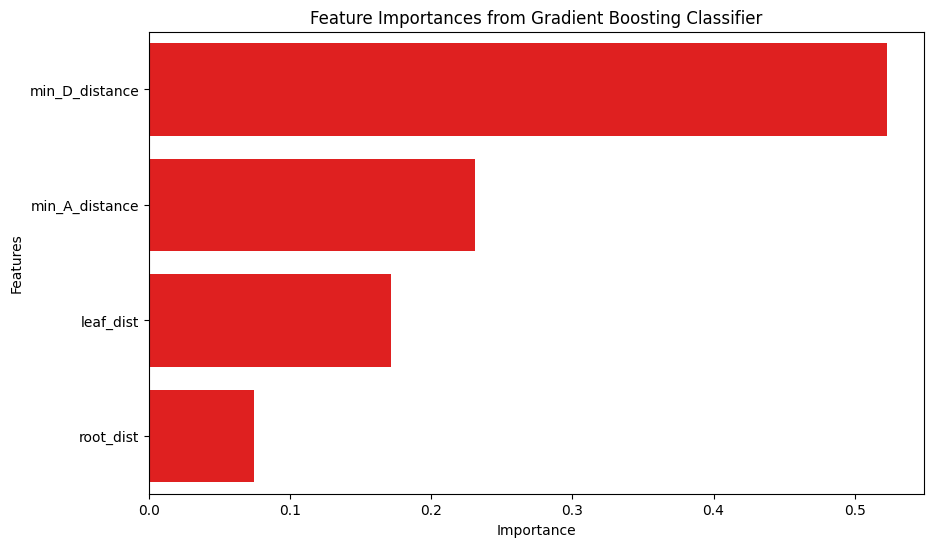

In [ ]:
feature_imp = pd.DataFrame(
{'importance':boost_clf.feature_importances_},
index=X_tr.columns) # Use X_tr.columns to get the correct features used by the model

# Sort the feature importances
feature_imp = feature_imp.sort_values(by='importance', ascending=False)

# Create the horizontal bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y=feature_imp.index, data=feature_imp, color = 'red')
plt.title('Feature Importances from Gradient Boosting Classifier')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()


In [ ]:
# Initialize the model
boost_clf_smote = GradientBoostingClassifier(
    n_estimators=100,     # number of boosting rounds
    learning_rate=0.1,    # shrinkage rate (default 0.1)
    max_depth=4,          # depth of each tree
    random_state=42
)

# Fit the model
boost_clf_smote.fit(X_resampled, y_resampled)

# Predict on test data
y_pred_smote = boost_clf_smote.predict(X_te)

# Evaluate
print(confusion_matrix(y_test, y_pred_smote))
print(classification_report(y_test, y_pred_smote))

[[235817  30418]
 [    73    411]]
              precision    recall  f1-score   support

           0       1.00      0.89      0.94    266235
           1       0.01      0.85      0.03       484

    accuracy                           0.89    266719
   macro avg       0.51      0.87      0.48    266719
weighted avg       1.00      0.89      0.94    266719



In [ ]:
#Predict on Neuron 1
boost_pred = boost_clf_smote.predict(fil_df)
print(confusion_matrix(neu_test, boost_pred))

[[1041  495]
 [   0    4]]


In [ ]:
filtered_df['boost_pred'] = boost_pred

In [ ]:
#Neural Networks
#Drop X_5
X_tr_nn = Xtr.drop(columns=["min_N_distance"])
X_te_nn = Xte.drop(columns=["min_N_distance"])
X_resampled_nn = X_resampled.copy()

from sklearn.preprocessing import StandardScaler
#Scale features
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr_nn)
X_resampled_nn = scaler.transform(X_resampled_nn)
fil_df = scaler.transform(fil_df)
X_te = scaler.transform(X_te_nn)

In [ ]:
#Now move onto Deep Learning Methods
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim

In [ ]:
# Convert to PyTorch tensors
X_tr = torch.tensor(X_tr, dtype=torch.float32)
y_tr = torch.tensor(y_train.values, dtype=torch.float32)
X_te = torch.tensor(X_te, dtype=torch.float32)
y_te = torch.tensor(y_test.values, dtype=torch.float32)
fil_df = torch.tensor(fil_df, dtype=torch.float32)
neu_test_tensor = torch.tensor(filtered_df['num_synapses'].values, dtype=torch.float32)

# Create DataLoaders
train_dataset = TensorDataset(X_tr, y_tr)
test_dataset = TensorDataset(X_te, y_te)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

<ipython-input-83-39e30c19b53a>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tr = torch.tensor(X_tr, dtype=torch.float32)
<ipython-input-83-39e30c19b53a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_te = torch.tensor(X_te, dtype=torch.float32)
<ipython-input-83-39e30c19b53a>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fil_df = torch.tensor(fil_df, dtype=torch.float32)


In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
#Tune hidden layer size

# Define the model class
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(BinaryClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

X_np = X_tr.numpy().astype(np.float32)
y_np = y_tr.numpy().astype(np.float32)

# Cross-validation settings
kf = KFold(n_splits=5, shuffle=True, random_state=0)
hidden_sizes = [4, 5, 6, 7, 8]
input_dim = X_tr.shape[1]
num_epochs = 200
results = {}

for h_size in hidden_sizes:
    fold_accuracies = []

    X_np = X_tr.numpy().astype(np.float32)
    y_np = y_tr.numpy().astype(np.float32)


    for train_idx, val_idx in kf.split(X_np):
        # Prepare data
        X_train_fold = torch.tensor(X_np[train_idx])
        y_train_fold = torch.tensor(y_np[train_idx]).unsqueeze(1)
        X_val_fold = torch.tensor(X_np[val_idx])
        y_val_fold = torch.tensor(y_np[val_idx]).unsqueeze(1)

        # Model
        model = BinaryClassifier(input_dim, h_size)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Training loop
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()
            output = model(X_train_fold)
            loss = criterion(output, y_train_fold)
            loss.backward()
            optimizer.step()

        # Evaluation
        model.eval()
        with torch.no_grad():
            preds = model(X_val_fold).squeeze()
            preds = (preds >= 0.5).int()
            acc = accuracy_score(y_val_fold.numpy(), preds.numpy())
            fold_accuracies.append(acc)

    results[h_size] = np.mean(fold_accuracies)
    print(f"Hidden Size {h_size}: Mean CV Accuracy = {results[h_size]:.4f}")

# Display best
best_size = max(results, key=results.get)
print(f"\nBest hidden layer size: {best_size} with CV accuracy: {results[best_size]:.4f}")


Hidden Size 4: Mean CV Accuracy = 0.9852
Hidden Size 5: Mean CV Accuracy = 0.9536
Hidden Size 6: Mean CV Accuracy = 0.9967
Hidden Size 7: Mean CV Accuracy = 0.9981
Hidden Size 8: Mean CV Accuracy = 0.9094

Best hidden layer size: 7 with CV accuracy: 0.9981


In [ ]:
#Single layer model
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim,8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
model = BinaryClassifier(X_tr.shape[1])
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 150
losses1= []
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x).squeeze()
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    with torch.no_grad():
        avg_pred = model(X_tr).mean().item()
    losses1.append(epoch_loss)
    print(f"Epoch {epoch+1}: Loss = {epoch_loss:.4f}, Avg prediction = {avg_pred:.6f}")

Epoch 1: Loss = 355.6288, Avg prediction = 0.002084
Epoch 2: Loss = 223.4684, Avg prediction = 0.002343
Epoch 3: Loss = 222.5131, Avg prediction = 0.002017
Epoch 4: Loss = 221.8095, Avg prediction = 0.001737
Epoch 5: Loss = 221.1732, Avg prediction = 0.001956
Epoch 6: Loss = 220.5535, Avg prediction = 0.002295
Epoch 7: Loss = 219.8352, Avg prediction = 0.002365
Epoch 8: Loss = 219.6149, Avg prediction = 0.002351
Epoch 9: Loss = 219.3267, Avg prediction = 0.002055
Epoch 10: Loss = 218.9729, Avg prediction = 0.001840
Epoch 11: Loss = 218.8330, Avg prediction = 0.001675
Epoch 12: Loss = 218.6266, Avg prediction = 0.002326
Epoch 13: Loss = 218.5448, Avg prediction = 0.002062
Epoch 14: Loss = 218.3237, Avg prediction = 0.002219
Epoch 15: Loss = 218.2592, Avg prediction = 0.001811
Epoch 16: Loss = 218.0692, Avg prediction = 0.001906
Epoch 17: Loss = 217.8659, Avg prediction = 0.001900
Epoch 18: Loss = 217.6266, Avg prediction = 0.002099
Epoch 19: Loss = 217.6864, Avg prediction = 0.001965
Ep

In [ ]:
#Higher learning rate
model2 = BinaryClassifier(X_tr.shape[1])
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.01)

# Training loop
epochs = 100
losses2= []
for epoch in range(epochs):
    model2.train()
    epoch_loss = 0.0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model2(batch_x).squeeze()
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    with torch.no_grad():
        avg_pred = model2(X_tr).mean().item()
    losses2.append(epoch_loss)
    print(f"Epoch {epoch+1}: Loss = {epoch_loss:.4f}, Avg prediction = {avg_pred:.6f}")

Epoch 1: Loss = 244.4195, Avg prediction = 0.002975
Epoch 2: Loss = 225.8556, Avg prediction = 0.002102
Epoch 3: Loss = 224.8864, Avg prediction = 0.002365
Epoch 4: Loss = 223.0024, Avg prediction = 0.001879
Epoch 5: Loss = 221.3332, Avg prediction = 0.002279
Epoch 6: Loss = 220.7503, Avg prediction = 0.002611
Epoch 7: Loss = 220.3910, Avg prediction = 0.001559
Epoch 8: Loss = 220.6691, Avg prediction = 0.001309
Epoch 9: Loss = 220.0168, Avg prediction = 0.002216
Epoch 10: Loss = 219.0372, Avg prediction = 0.002277
Epoch 11: Loss = 219.5762, Avg prediction = 0.001353
Epoch 12: Loss = 219.1536, Avg prediction = 0.001475
Epoch 13: Loss = 218.6529, Avg prediction = 0.001266
Epoch 14: Loss = 217.9812, Avg prediction = 0.002601
Epoch 15: Loss = 218.1805, Avg prediction = 0.000929


KeyboardInterrupt: 

In [ ]:
#Lower learning rate
model3 = BinaryClassifier(X_tr.shape[1])
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=0.0001)

# Training loop
epochs = 100
losses3= []
for epoch in range(epochs):
    model3.train()
    epoch_loss = 0.0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model3(batch_x).squeeze()
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    with torch.no_grad():
        avg_pred = model3(X_tr).mean().item()
    losses3.append(epoch_loss)
    print(f"Epoch {epoch+1}: Loss = {epoch_loss:.4f}, Avg prediction = {avg_pred:.6f}")

In [ ]:
epochs = 100
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x).squeeze()
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    with torch.no_grad():
        avg_pred = model(X_tr).mean().item()
    losses1.append(epoch_loss)
    print(f"Epoch {epoch+101}: Loss = {epoch_loss:.4f}, Avg prediction = {avg_pred:.6f}")

Epoch 101: Loss = 212.6647, Avg prediction = 0.002784
Epoch 102: Loss = 212.4625, Avg prediction = 0.002134
Epoch 103: Loss = 212.5364, Avg prediction = 0.001861
Epoch 104: Loss = 212.4152, Avg prediction = 0.001924
Epoch 105: Loss = 212.3987, Avg prediction = 0.001697
Epoch 106: Loss = 212.3396, Avg prediction = 0.002089
Epoch 107: Loss = 212.4825, Avg prediction = 0.001404
Epoch 108: Loss = 212.2844, Avg prediction = 0.001975
Epoch 109: Loss = 212.2920, Avg prediction = 0.001936
Epoch 110: Loss = 212.3618, Avg prediction = 0.002201
Epoch 111: Loss = 212.2592, Avg prediction = 0.001432
Epoch 112: Loss = 212.2190, Avg prediction = 0.001825
Epoch 113: Loss = 212.3098, Avg prediction = 0.001772
Epoch 114: Loss = 212.1520, Avg prediction = 0.001614
Epoch 115: Loss = 212.2254, Avg prediction = 0.002240
Epoch 116: Loss = 212.1601, Avg prediction = 0.002838
Epoch 117: Loss = 212.1512, Avg prediction = 0.002009
Epoch 118: Loss = 212.1542, Avg prediction = 0.001709
Epoch 119: Loss = 212.1110, 

In [ ]:
#Adjust learning rate for further convergence
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

epochs = 100
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x).squeeze()
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    with torch.no_grad():
        avg_pred = model(X_tr).mean().item()
    losses1.append(epoch_loss)
    print(f"Epoch {epoch+151}: Loss = {epoch_loss:.4f}, Avg prediction = {avg_pred:.6f}")

Epoch 151: Loss = 210.6239, Avg prediction = 0.002042
Epoch 152: Loss = 210.4906, Avg prediction = 0.002007
Epoch 153: Loss = 210.3856, Avg prediction = 0.001877
Epoch 154: Loss = 210.4228, Avg prediction = 0.001929
Epoch 155: Loss = 210.3187, Avg prediction = 0.001792
Epoch 156: Loss = 210.3955, Avg prediction = 0.002070
Epoch 157: Loss = 210.3398, Avg prediction = 0.002018
Epoch 158: Loss = 210.3765, Avg prediction = 0.002131
Epoch 159: Loss = 210.3551, Avg prediction = 0.002073
Epoch 160: Loss = 210.3596, Avg prediction = 0.001859
Epoch 161: Loss = 210.3590, Avg prediction = 0.001919
Epoch 162: Loss = 210.4127, Avg prediction = 0.001972
Epoch 163: Loss = 210.3507, Avg prediction = 0.001823
Epoch 164: Loss = 210.3569, Avg prediction = 0.001876
Epoch 165: Loss = 210.3459, Avg prediction = 0.001905
Epoch 166: Loss = 210.3232, Avg prediction = 0.001854
Epoch 167: Loss = 210.3537, Avg prediction = 0.002073
Epoch 168: Loss = 210.3544, Avg prediction = 0.001901
Epoch 169: Loss = 210.3524, 

KeyboardInterrupt: 

In [ ]:
#Plot effect of adjusting lr
plt.figure(figsize=(10, 6))
plt.plot(losses1[1:], label='Losses')
plt.axvline(x=199, color='r', linestyle=':', label='Epoch 200')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

In [ ]:
#Confusion matrix on large test set
probs_nn = model(X_te).squeeze().detach().numpy()
preds_nn = (probs_nn >= 0.5).astype(int)

In [ ]:
print(confusion_matrix(y_test, preds_nn))
print(classification_report(y_test, preds_nn, digits=4))

[[266235      0]
 [   484      0]]
              precision    recall  f1-score   support

           0     0.9982    1.0000    0.9991    266235
           1     0.0000    0.0000    0.0000       484

    accuracy                         0.9982    266719
   macro avg     0.4991    0.5000    0.4995    266719
weighted avg     0.9964    0.9982    0.9973    266719



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
filtered_df['nn_prob'] = model(fil_df).squeeze().detach().numpy()

In [ ]:
# Convert to PyTorch tensors
X_resampled_nn = torch.tensor(X_resampled_nn, dtype=torch.float32)
y_resampled_nn = torch.tensor(y_resampled.values, dtype=torch.float32)


# Create DataLoaders
train_dataset = TensorDataset(X_resampled_nn, y_resampled_nn)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [ ]:
#SMOTE data set
model4 = BinaryClassifier(X_resampled_nn.shape[1])
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model4.parameters(), lr=0.001)

# Convert X_resampled to a PyTorch Tensor for evaluation
X_resampled_tensor_eval = X_resampled_nn

# Training loop
epochs = 100
losses4= []
for epoch in range(epochs):
    model4.train()
    epoch_loss = 0.0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model4(batch_x).squeeze()
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    with torch.no_grad():
        # Use the PyTorch tensor version of X_resampled
        avg_pred = model4(X_resampled_tensor_eval).mean().item()
    losses4.append(epoch_loss)
    print(f"Epoch {epoch+1}: Loss = {epoch_loss:.4f}, Avg prediction = {avg_pred:.6f}")

Epoch 1: Loss = 17746.6782, Avg prediction = 0.505018
Epoch 2: Loss = 15820.2015, Avg prediction = 0.504065
Epoch 3: Loss = 15194.2274, Avg prediction = 0.501848
Epoch 4: Loss = 14814.0975, Avg prediction = 0.507451
Epoch 5: Loss = 14530.9794, Avg prediction = 0.505820
Epoch 6: Loss = 14295.3140, Avg prediction = 0.504688
Epoch 7: Loss = 14073.8073, Avg prediction = 0.516334
Epoch 8: Loss = 13891.4171, Avg prediction = 0.496522
Epoch 9: Loss = 13733.2124, Avg prediction = 0.506580
Epoch 10: Loss = 13598.7300, Avg prediction = 0.488566
Epoch 11: Loss = 13477.5037, Avg prediction = 0.514355
Epoch 12: Loss = 13371.4816, Avg prediction = 0.514385
Epoch 13: Loss = 13273.3736, Avg prediction = 0.480430
Epoch 14: Loss = 13185.5173, Avg prediction = 0.504884
Epoch 15: Loss = 13104.8081, Avg prediction = 0.524195
Epoch 16: Loss = 13029.0124, Avg prediction = 0.496689
Epoch 17: Loss = 12956.4939, Avg prediction = 0.519770
Epoch 18: Loss = 12894.8785, Avg prediction = 0.510742
Epoch 19: Loss = 12

In [ ]:
#Prediciton on large test set for SMOTE data
probs_nn = model4(X_te).squeeze().detach().numpy()
preds_nn = (probs_nn >= 0.5).astype(int)

print(confusion_matrix(y_test, preds_nn))
print(classification_report(y_test, preds_nn, digits=4))

[[203389  62846]
 [    56    428]]
              precision    recall  f1-score   support

           0     0.9997    0.7639    0.8661    266235
           1     0.0068    0.8843    0.0134       484

    accuracy                         0.7642    266719
   macro avg     0.5032    0.8241    0.4398    266719
weighted avg     0.9979    0.7642    0.8645    266719



In [ ]:
#Multi-layer model
class BinaryClassifier2(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassifier2, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 8),
            nn.ReLU(),
            #nn.Dropout(0.3),
            nn.Linear(8, 4),
            nn.ReLU(),
            #nn.Dropout(0.3),
            nn.Linear(4, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
model5 = BinaryClassifier2(X_tr.shape[1])
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model5.parameters(), lr=0.001)

# Training loop
epochs = 150
losses5 = []
for epoch in range(epochs):
    model5.train()
    epoch_loss = 0.0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model5(batch_x).squeeze()
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    with torch.no_grad():
        avg_pred = model5(X_tr).mean().item()
    losses5.append(epoch_loss)
    print(f"Epoch {epoch+1}: Loss = {epoch_loss:.4f}, Avg prediction = {avg_pred:.6f}")

Epoch 1: Loss = 18672.9289, Avg prediction = 0.363574
Epoch 2: Loss = 16998.7783, Avg prediction = 0.342959
Epoch 3: Loss = 16740.0317, Avg prediction = 0.340350
Epoch 4: Loss = 16651.6819, Avg prediction = 0.345916


KeyboardInterrupt: 

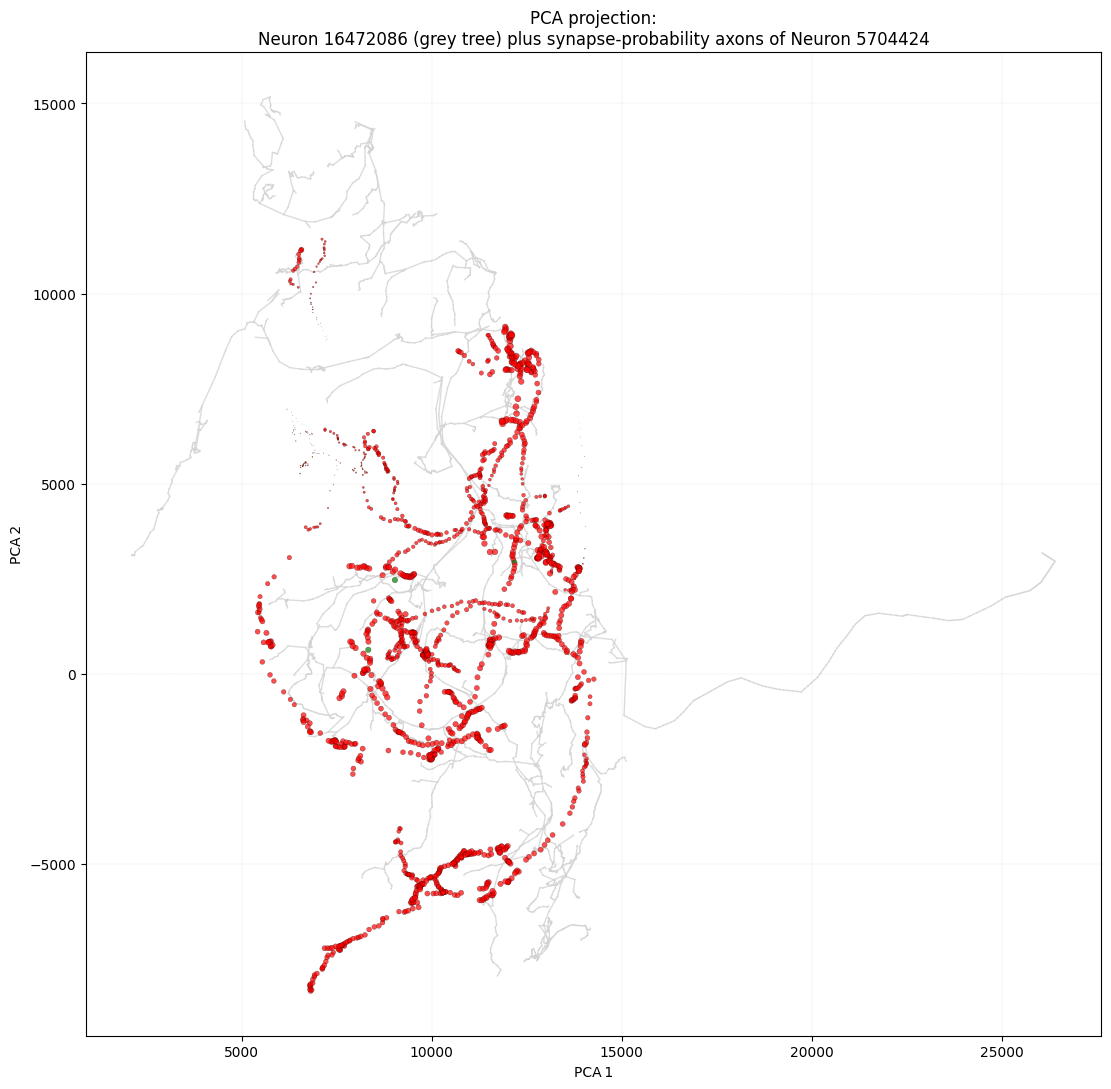

In [ ]:
from sklearn.decomposition import PCA

# Load morphologies  &  predicted probabilities
df1 = pd.read_csv("morpho_neuron-ID_5704424.csv")   # presynaptic neuron
df2 = pd.read_csv("morpho_neuron-ID_16472086.csv")  # postsynaptic neuron



#Build a common 2-D PCA projection
both_coords = pd.concat([df1[['x', 'y', 'z']], df2[['x', 'y', 'z']]], ignore_index=True)
pca_xy      = PCA(n_components=2).fit_transform(both_coords)

# split back to neuron-specific arrays
pca1 = pca_xy[:len(df1)]
pca2 = pca_xy[len(df1):]

df1["pca1"], df1["pca2"] = pca1[:, 0], pca1[:, 1]
df2["pca1"], df2["pca2"] = pca2[:, 0], pca2[:, 1]

# map node_id → (pca1, pca2)
pca_lookup1 = df1.set_index("node_id")[["pca1", "pca2"]].to_dict("index")
pca_lookup2 = df2.set_index("node_id")[["pca1", "pca2"]].to_dict("index")


#Plot

fig, ax = plt.subplots(figsize=(14, 11))

#Background: neuron-2 morphology (light-grey tree)
for _, row in df2.iterrows():
    if row["node_type"] == "axon":
        continue  # Skip axon branches
    parent_id = row["parent_id"]
    if parent_id in pca_lookup2 and parent_id != -1:
        x_child, y_child = row["pca1"], row["pca2"]
        x_par,  y_par    = pca_lookup2[parent_id]["pca1"], pca_lookup2[parent_id]["pca2"]
        ax.plot([x_child, x_par], [y_child, y_par],
                color="lightgrey", lw=1.0, alpha=0.8, zorder=0)

#Axon nodes of neuron-1 with size ∝ probability
#merge probabilities onto df1
df1 = df1.merge(filtered_df[["src_node_ID", "log_prob"]], left_on="node_id", right_on="src_node_ID", how="left")


# list of axon-nodes that actually form a synapse
true_synapse_ids = [5704428, 11241870, 18907541, 24311049]

# choose a marker size scale
size_scale = 2000

axon_df = df1[df1["node_type"] == "axon"].copy()

# Colour map: green if node forms a synapse, else red
axon_df["colour"] = np.where(axon_df["node_id"].isin(true_synapse_ids),
                             "green", "red")

ax.scatter(axon_df["pca1"], axon_df["pca2"],
           s=axon_df["log_prob"] * size_scale,
           c=axon_df['colour'], alpha=0.7, edgecolor="k", linewidth=0.2, zorder=2,
           label="Neuron 5704424 axon (size ∝ P(synapse))")

ax.set_title("PCA projection:\nNeuron 16472086 (grey tree) plus synapse-probability axons of Neuron 5704424")
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_aspect("equal")
ax.grid(True, linestyle="--", linewidth=0.3, alpha=0.4)

plt.tight_layout()
plt.show()


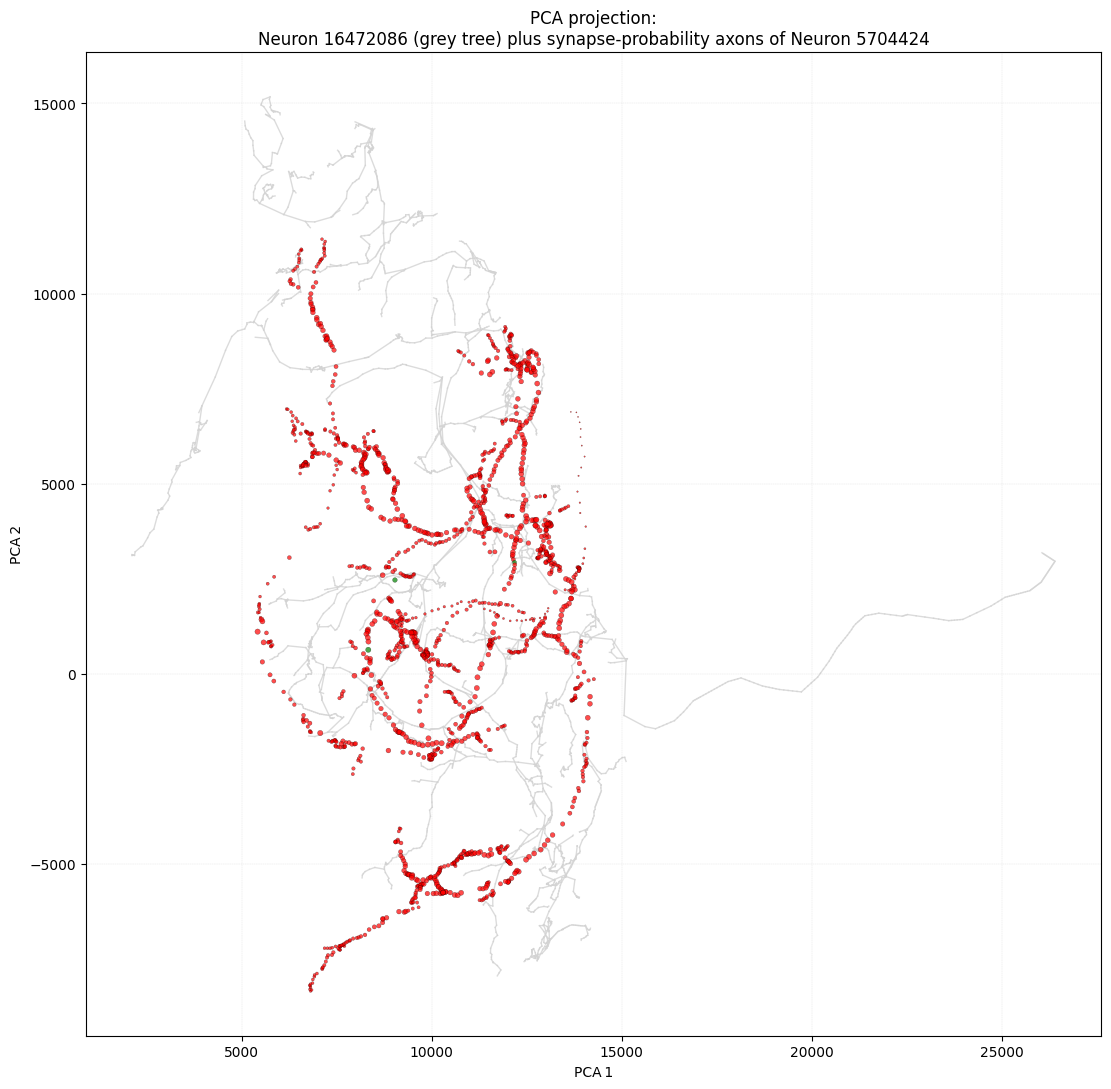

In [ ]:
#Load morphologies  &  predicted probabilities
df1 = pd.read_csv("morpho_neuron-ID_5704424.csv")   # presynaptic neuron
df2 = pd.read_csv("morpho_neuron-ID_16472086.csv")  # postsynaptic neuron

#Build a common 2-D PCA projection
both_coords = pd.concat([df1[['x', 'y', 'z']], df2[['x', 'y', 'z']]], ignore_index=True)
pca_xy      = PCA(n_components=2).fit_transform(both_coords)

#split back to neuron-specific arrays
pca1 = pca_xy[:len(df1)]
pca2 = pca_xy[len(df1):]

df1["pca1"], df1["pca2"] = pca1[:, 0], pca1[:, 1]
df2["pca1"], df2["pca2"] = pca2[:, 0], pca2[:, 1]

#map node_id → (pca1, pca2)
pca_lookup1 = df1.set_index("node_id")[["pca1", "pca2"]].to_dict("index")
pca_lookup2 = df2.set_index("node_id")[["pca1", "pca2"]].to_dict("index")


#Plot

fig, ax = plt.subplots(figsize=(14, 11))

#Background: neuron-2 morphology (light-grey tree)
for _, row in df2.iterrows():
    if row["node_type"] == "axon":
        continue  # Skip axon branches
    parent_id = row["parent_id"]
    if parent_id in pca_lookup2 and parent_id != -1:
        x_child, y_child = row["pca1"], row["pca2"]
        x_par,  y_par    = pca_lookup2[parent_id]["pca1"], pca_lookup2[parent_id]["pca2"]
        ax.plot([x_child, x_par], [y_child, y_par],
                color="lightgrey", lw=1.0, alpha=0.8, zorder=0)

#Axon nodes of neuron-1 with size ∝ probability
#merge probabilities onto df1
df1 = df1.merge(filtered_df[["src_node_ID", "nn_prob"]], left_on="node_id", right_on="src_node_ID", how="left")


#list of axon-nodes that actually form a synapse
true_synapse_ids = [5704428, 11241870, 18907541, 24311049]

#choose a marker size scale
size_scale = 2000

axon_df = df1[df1["node_type"] == "axon"].copy()

#Colour map: green if node forms a synapse, else red
axon_df["colour"] = np.where(axon_df["node_id"].isin(true_synapse_ids),
                             "green", "red")

ax.scatter(axon_df["pca1"], axon_df["pca2"],
           s=axon_df["nn_prob"] * size_scale,
           c=axon_df['colour'], alpha=0.7, edgecolor="k", linewidth=0.2, zorder=2,
           label="Neuron 5704424 axon (size ∝ P(synapse))")


ax.set_title("PCA projection:\nNeuron 16472086 (grey tree) plus synapse-probability axons of Neuron 5704424")
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_aspect("equal")
ax.grid(True, linestyle="--", linewidth=0.3, alpha=0.4)
plt.tight_layout()
plt.show()


In [ ]:
df1 = df1.drop(columns = ['boost_pred_x', 'boost_pred_y', 'src_node_ID_x', 'src_node_ID_y'])

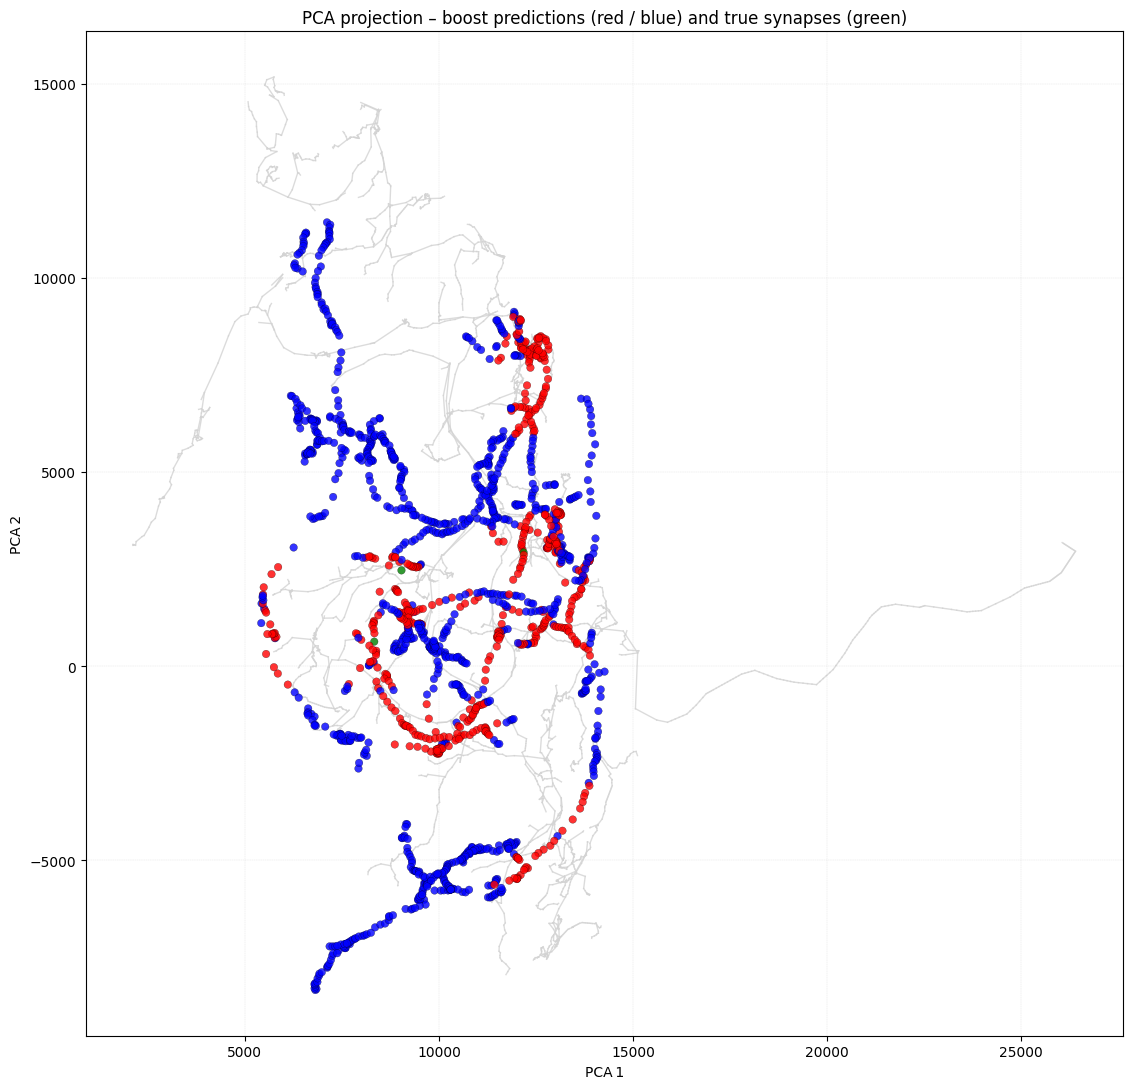

In [ ]:
#binary boost prediction on smote

fig, ax = plt.subplots(figsize=(14, 11))

#Background: neuron-2 dendrites only (grey)
for _, row in df2.iterrows():
    if row["node_type"] == "axon":          #skip axon branches
        continue
    parent_id = row["parent_id"]
    if parent_id in pca_lookup2 and parent_id != -1:
        xc, yc = row["pca1"], row["pca2"]
        xp, yp = pca_lookup2[parent_id]["pca1"], pca_lookup2[parent_id]["pca2"]
        ax.plot([xc, xp], [yc, yp],
                color="lightgrey", lw=1.0, alpha=0.8, zorder=0)


true_synapse_ids = [5704428, 11241870, 18907541, 24311049]

#merge boost predictions onto df1
df1 = df1.merge(filtered_df[["src_node_ID", "boost_pred"]],
                left_on="node_id", right_on="src_node_ID", how="left")

axon_df = df1[df1["node_type"] == "axon"].copy()

#assign colour
def colour_row(row):
    if row["node_id"] in true_synapse_ids:
        return "green"
    return "red" if row["boost_pred"] == 1 else "blue"

axon_df["colour"] = axon_df.apply(colour_row, axis=1)

ax.scatter(axon_df["pca1"], axon_df["pca2"],
           s=30,                         #uniform size
           c=axon_df["colour"],
           alpha=0.8, edgecolor="k", linewidth=0.2, zorder=2)


ax.set_title("PCA projection – boost predictions (red / blue) and true synapses (green)")
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_aspect("equal")
ax.grid(True, linestyle="--", linewidth=0.3, alpha=0.4)
plt.tight_layout()
plt.show()


In [ ]:
X_tr = X_tr.drop(columns = ['const', 'min_N_distance'])

In [ ]:
X_te = X_te.drop(columns = ['const', 'min_N_distance'])

In [ ]:
fil_df = filtered_df[features]

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
#Train on rbf kernel
X_small = X_tr[:500000]
y_small = y_train[:500000]
svm_clf = SVC(kernel='rbf', C=1.2, probability=True)
svm_clf.fit(X_small, y_small)

SVC(C=1.2, probability=True)

In [ ]:
y_probs_svm = svm_clf.predict_proba(X_te)
y_preds_svm = (y_probs_svm[:,1] > 0.5).astype(int)
print(confusion_matrix(y_test, y_preds_svm))
print(classification_report(y_test, y_preds_svm, digits=4))

[[266235      0]
 [   484      0]]
              precision    recall  f1-score   support

           0     0.9982    1.0000    0.9991    266235
           1     0.0000    0.0000    0.0000       484

    accuracy                         0.9982    266719
   macro avg     0.4991    0.5000    0.4995    266719
weighted avg     0.9964    0.9982    0.9973    266719



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
y_probs_svm[:,1]

array([0.00241659, 0.00199365, 0.00196447, ..., 0.0020423 , 0.00218205,
       0.00248   ])

In [ ]:
svm_loss = log_loss(y_test, y_probs_svm[:,1])
svm_loss

0.01298498999607788

In [ ]:
fil_df = fil_df.drop(columns = ['min_N_distance'])

In [ ]:
svm_probs2 = svm_clf.predict_proba(fil_df)

In [ ]:
filtered_df['svm_prob'] = svm_probs2[:,1]

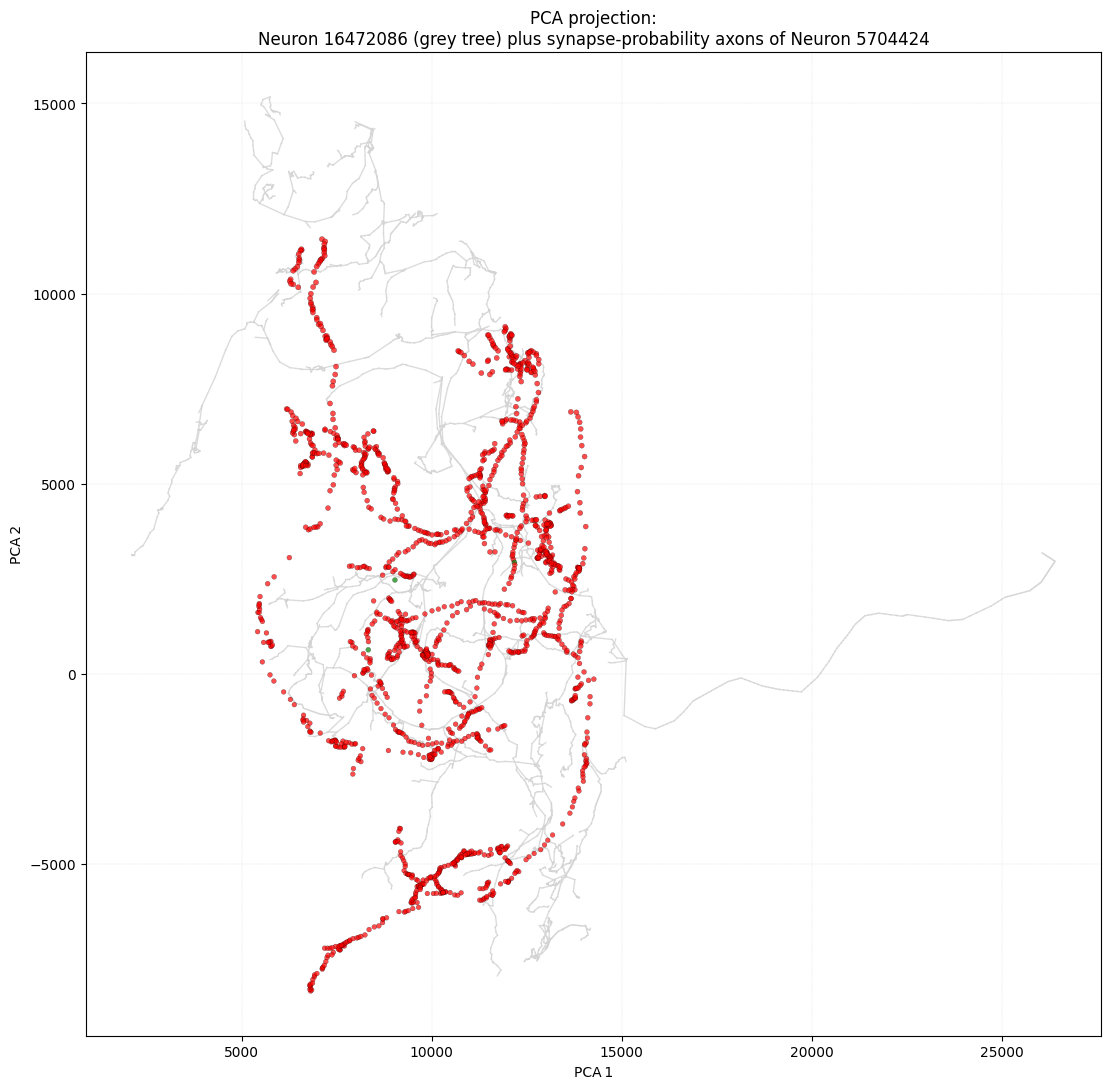

In [ ]:
from sklearn.decomposition import PCA

df1 = pd.read_csv("morpho_neuron-ID_5704424.csv")   # presynaptic neuron
df2 = pd.read_csv("morpho_neuron-ID_16472086.csv")  # postsynaptic neuron

#Build a common 2-D PCA projection

both_coords = pd.concat([df1[['x', 'y', 'z']], df2[['x', 'y', 'z']]], ignore_index=True)
pca_xy      = PCA(n_components=2).fit_transform(both_coords)

# split back to neuron-specific arrays
pca1 = pca_xy[:len(df1)]
pca2 = pca_xy[len(df1):]

df1["pca1"], df1["pca2"] = pca1[:, 0], pca1[:, 1]
df2["pca1"], df2["pca2"] = pca2[:, 0], pca2[:, 1]

# map node_id → (pca1, pca2)
pca_lookup1 = df1.set_index("node_id")[["pca1", "pca2"]].to_dict("index")
pca_lookup2 = df2.set_index("node_id")[["pca1", "pca2"]].to_dict("index")

#plot
fig, ax = plt.subplots(figsize=(14, 11))

#Background: neuron-2 morphology (light-grey tree)
for _, row in df2.iterrows():
    if row["node_type"] == "axon":
        continue  # Skip axon branches
    parent_id = row["parent_id"]
    if parent_id in pca_lookup2 and parent_id != -1:
        x_child, y_child = row["pca1"], row["pca2"]
        x_par,  y_par    = pca_lookup2[parent_id]["pca1"], pca_lookup2[parent_id]["pca2"]
        ax.plot([x_child, x_par], [y_child, y_par],
                color="lightgrey", lw=1.0, alpha=0.8, zorder=0)

#Axon nodes of neuron-1 with size ∝ probability
# merge probabilities onto df1
df1 = df1.merge(filtered_df[["src_node_ID", "svm_prob"]], left_on="node_id", right_on="src_node_ID", how="left")


# list of axon-nodes that actually form a synapse
true_synapse_ids = [5704428, 11241870, 18907541, 24311049]

#marker size scale
size_scale = 6000

axon_df = df1[df1["node_type"] == "axon"].copy()

# Colour map: green if node forms a synapse, else red
axon_df["colour"] = np.where(axon_df["node_id"].isin(true_synapse_ids),
                             "green", "red")

ax.scatter(axon_df["pca1"], axon_df["pca2"],
           s=axon_df["svm_prob"] * size_scale,
           c=axon_df['colour'], alpha=0.7, edgecolor="k", linewidth=0.2, zorder=2,
           label="Neuron 5704424 axon (size ∝ P(synapse))")


ax.set_title("PCA projection:\nNeuron 16472086 (grey tree) plus synapse-probability axons of Neuron 5704424")
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_aspect("equal")
ax.grid(True, linestyle="--", linewidth=0.3, alpha=0.4)

plt.tight_layout()
plt.show()


array([0.00199067, 0.00198878, 0.00198888, ..., 0.00210117, 0.00235135,
       0.00235063])